# Clue Project

In this notebook, we split our process tasks in two. We walk through the process of normalizing our dataset and then, read in the data from our normalized database for use in predicting the result of a match between two opponents. We will use functions and the ideas from this notebook to write our processing scripts.

**Task list** <br>
As as defined below:
Create a Python 3.* that parses the NBA statistics provided in the attached files:
- Dump the statistics into a MySQL database in a normalized format
- Create a user facing functionality to retrieve the following data points:
- The best player in terms of productivity for each week of the selected season (each point/rebound/assist counts the same)
- Prediction of a match result between two teams (the prediction model is up to you to create, the more interesting, the best)
- (Exterior) The program can be web facing (FLASK) or command line only

## Task 1: Basketball Dataset Normalization

To understand the dataset, I first searched for explanatory information on our statistics which are available here: [Wikipedia on Statistics](https://en.wikipedia.org/wiki/Basketball_statistics)

Our data files in "archive.zip" contains 5 csv files:
   1. 'teams.csv'
   2. 'players.csv'
   3. 'games.csv',
   4. 'ranking.csv'
   5. 'games_details.csv'
   

Our task is to breakdown our dataset into normalized (3rdNF) and write to an SQL database. Each csv is read in and parsed with the pandas library.

In [820]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
from sqlalchemy import create_engine

In [821]:
#!pip install googledrivedownloader

In [822]:
#from google_drive_downloader import GoogleDriveDownloader as gdd

#drive_path = '1N2ECsbiCkNDq4ilEVbMIkKz3WESvlG1_'
#parent_dir = 'data'
#file_name = '/archive.zip'

#gdd.download_file_from_google_drive(file_id = drive_path,
#                                    dest_path=parent_dir+file_name,
#                                    unzip=True)

In [823]:
import zipfile

parent_dir = 'data'
file_name = 'archive.zip'

with zipfile.ZipFile(file_name, "r") as zip_ref:
    zip_ref.extractall("data")

In [824]:
datasets = [parent_dir+'/'+file_name for file_name in  os.listdir('data')]
sorted(datasets)

['data/games.csv',
 'data/games_details.csv',
 'data/players.csv',
 'data/ranking.csv',
 'data/teams.csv']

### 1: Refactoring the Teams CSV
To normalize the data available in teams.csv can be split into the teams and arenas databases. 

In [825]:
teams = pd.read_csv(datasets[0])
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [826]:
teams.dtypes

LEAGUE_ID               int64
TEAM_ID                 int64
MIN_YEAR                int64
MAX_YEAR                int64
ABBREVIATION           object
NICKNAME               object
YEARFOUNDED             int64
CITY                   object
ARENA                  object
ARENACAPACITY         float64
OWNER                  object
GENERALMANAGER         object
HEADCOACH              object
DLEAGUEAFFILIATION     object
dtype: object

**MISSING DATA**

In [827]:
teams.isna().sum()

LEAGUE_ID             0
TEAM_ID               0
MIN_YEAR              0
MAX_YEAR              0
ABBREVIATION          0
NICKNAME              0
YEARFOUNDED           0
CITY                  0
ARENA                 0
ARENACAPACITY         4
OWNER                 0
GENERALMANAGER        0
HEADCOACH             0
DLEAGUEAFFILIATION    0
dtype: int64

**CONSISTENCY CHECK**

In [828]:
print(f'We have {teams["TEAM_ID"].nunique()} unique teams: ')
print(teams["TEAM_ID"].unique())

We have 30 unique teams: 
[1610612737 1610612738 1610612740 1610612741 1610612742 1610612743
 1610612745 1610612746 1610612747 1610612748 1610612749 1610612750
 1610612751 1610612752 1610612753 1610612754 1610612755 1610612756
 1610612757 1610612758 1610612759 1610612760 1610612761 1610612762
 1610612763 1610612764 1610612765 1610612766 1610612739 1610612744]


In [829]:
teams.duplicated().sum()

0

**FINAL SORT**

We will rearrange and rename our columns to make for clearer insertion into our db later on

In [830]:
#creating an arenas table from the teams table
cols = ['TEAM_ID','LEAGUE_ID'] + list(teams.columns)[2:]
teams = teams.reindex(columns=cols)

teams = teams.drop(columns=['YEARFOUNDED'])

teams.head()

,TEAM_ID,LEAGUE_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,1610612737,0,1949,2019,ATL,Hawks,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,1610612738,0,1946,2019,BOS,Celtics,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,1610612740,0,2002,2019,NOP,Pelicans,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,1610612741,0,1966,2019,CHI,Bulls,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,1610612742,0,1980,2019,DAL,Mavericks,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [831]:
teams = teams.rename(columns={'TEAM_ID': 'team_id',
                      'LEAGUE_ID': 'league_id',
                      'MIN_YEAR': 'min_year',
                      'MAX_YEAR': 'max_year',
                      'ABBREVIATION': 'abbreviation',
                      'NICKNAME': 'nickname',
                      'CITY': 'city',
                      'ARENA': 'arena',
                      'ARENACAPACITY': 'arena_capacity',
                      'OWNER': 'owner',
                      'GENERALMANAGER': 'generalmanager',
                      'HEADCOACH': 'headcoach',
                      'DLEAGUEAFFILIATION': 'd_league_affiliation'})
teams.head()

,team_id,league_id,min_year,max_year,abbreviation,nickname,city,arena,arena_capacity,owner,generalmanager,headcoach,d_league_affiliation
0,1610612737,0,1949,2019,ATL,Hawks,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,1610612738,0,1946,2019,BOS,Celtics,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,1610612740,0,2002,2019,NOP,Pelicans,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,1610612741,0,1966,2019,CHI,Bulls,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,1610612742,0,1980,2019,DAL,Mavericks,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


When creating our team data table, we want to use the Team_ID as our primary key.

### 2: Refactoring the Players CSV

A look at the next, file, the players csv containing player information:

In [832]:
players = pd.read_csv(datasets[1])
players.sample(5)

,PLAYER_NAME,TEAM_ID,PLAYER_ID,SEASON
6011,Jason Kidd,1610612742,467,2010
4716,CJ Leslie,1610612752,203466,2013
2320,Andrew Wiggins,1610612750,203952,2016
2057,Amida Brimah,1610612759,1628578,2017
1568,Dejounte Murray,1610612759,1627749,2017


In [833]:
players.dtypes

PLAYER_NAME    object
TEAM_ID         int64
PLAYER_ID       int64
SEASON          int64
dtype: object

**MISSING DATA**

In [834]:
players.isna().sum()

PLAYER_NAME    0
TEAM_ID        0
PLAYER_ID      0
SEASON         0
dtype: int64

**CONSISTENCY CHECK**

Check to see if the team id's and id's in the players columns match

In [835]:
assert(sorted(players["TEAM_ID"].unique()) == sorted(teams["team_id"].unique()))

In [836]:
players.duplicated().sum()

0

**FINAL SORT**

The data in the players csv file seems just fine and not in need of cleaning. We can break the current players table two tables for players and team_players. Team players links players to teams and seasons. We will use the Player_ID as primary key in the player table. 

In team_players, we use the Player_ID and TEAM_ID to reference the Teams and Players tables.

In [837]:
print(f'We have {players.PLAYER_ID.nunique()} unique players')

We have 1769 unique players


In [838]:
cols = ['PLAYER_ID','TEAM_ID','PLAYER_NAME','SEASON']

players = players.reindex(columns=cols)
players.sample(5)

,PLAYER_ID,TEAM_ID,PLAYER_NAME,SEASON
1278,203130,1610612750,Darius Johnson-Odom,2018
3942,202390,1610612766,Gary Neal,2014
4218,200746,1610612757,LaMarcus Aldridge,2013
2154,203078,1610612764,Bradley Beal,2016
5944,202081,1610612756,Garret Siler,2011


In [839]:
players = players.rename(columns={'PLAYER_ID': 'player_id',
                                  'PLAYER_NAME':'player_name',
                                  'TEAM_ID': 'team_id',
                                  'SEASON': 'season'})
players.head()

,player_id,team_id,player_name,season
0,1626220,1610612762,Royce O'Neale,2019
1,202711,1610612762,Bojan Bogdanovic,2019
2,203497,1610612762,Rudy Gobert,2019
3,1628378,1610612762,Donovan Mitchell,2019
4,201144,1610612762,Mike Conley,2019


In [840]:
team_players = players.drop(columns=['player_name'])
team_players.head()

,player_id,team_id,season
0,1626220,1610612762,2019
1,202711,1610612762,2019
2,203497,1610612762,2019
3,1628378,1610612762,2019
4,201144,1610612762,2019


In [841]:
players = players.drop(columns=['season','team_id'])
players.drop_duplicates(inplace=True)
players.head()

,player_id,player_name
0,1626220,Royce O'Neale
1,202711,Bojan Bogdanovic
2,203497,Rudy Gobert
3,1628378,Donovan Mitchell
4,201144,Mike Conley


### 3: Refactoring the Rankings CSV

A look at the third file, rankings csv

In [842]:
ranking = pd.read_csv(datasets[3])
ranking.sample(2)

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
32085,1610612759,0,22010,2010-12-01,West,San Antonio,18,15,3,0.833,7-2,8-1,NaN
69044,1610612744,0,22003,2004-02-17,West,Golden State,51,23,28,0.451,17-8,6-20,NaN


In [843]:
ranking.dtypes

TEAM_ID            int64
LEAGUE_ID          int64
SEASON_ID          int64
STANDINGSDATE     object
CONFERENCE        object
TEAM              object
G                  int64
W                  int64
L                  int64
W_PCT            float64
HOME_RECORD       object
ROAD_RECORD       object
RETURNTOPLAY     float64
dtype: object

Checking for unique dates and season ids

In [844]:
ranking.STANDINGSDATE.unique().shape

(6292,)

In [845]:
print(sorted(ranking['SEASON_ID'].unique()))

[12003, 12004, 12005, 12006, 12007, 12008, 12009, 12010, 12011, 12012, 12013, 12014, 12015, 12016, 12017, 12018, 12019, 12020, 22002, 22003, 22004, 22005, 22006, 22007, 22008, 22009, 22010, 22011, 22012, 22013, 22014, 22015, 22016, 22017, 22018, 22019]


**MISSING DATA**

In [846]:
ranking.isna().sum()

TEAM_ID               0
LEAGUE_ID             0
SEASON_ID             0
STANDINGSDATE         0
CONFERENCE            0
TEAM                  0
G                     0
W                     0
L                     0
W_PCT                 0
HOME_RECORD           0
ROAD_RECORD           0
RETURNTOPLAY     184393
dtype: int64

Note: some missing values in the RETURNTOPLAY column we will have to deal with. Lets take a look.

In [847]:
ranking[ranking.RETURNTOPLAY.isna()].head()

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612747,0,12020,2020-12-21,West,L.A. Lakers,4,4,0,1.00,2-0,2-0,NaN
1,1610612762,0,12020,2020-12-21,West,Utah,3,3,0,1.00,2-0,1-0,NaN
2,1610612740,0,12020,2020-12-21,West,New Orleans,2,2,0,1.00,1-0,1-0,NaN
3,1610612745,0,12020,2020-12-21,West,Houston,4,3,1,0.75,2-0,1-1,NaN
4,1610612763,0,12020,2020-12-21,West,Memphis,4,3,1,0.75,1-1,2-0,NaN


**CONSISTENCY CHECK**

In [848]:
assert(sorted(ranking["TEAM_ID"].unique()) == sorted(teams["team_id"].unique()))

In [849]:
ranking.duplicated().sum()

0

**FINAL SORT**

The *LEAGUE_ID*, *TEAM_ID* are duplicates from the Teams table and hence we do not need it. Also, win percentage W_PCT is equal to $\frac{W}{G}$

While this could be normalized further with the information from the games table, we will leave this as is because the information in the games data (as we will see soon) has some missing info that may make recalculating the standings difficult

In [850]:
ranking.drop(columns=['LEAGUE_ID','TEAM','W_PCT'], inplace=True)

ranking = ranking.rename(columns={'TEAM_ID': 'team_id','SEASON_ID': 'season_id',
                          'STANDINGSDATE': 'standings_date','CONFERENCE': 'conference',
                          'G': 'games','W': 'wins',
                          'L': 'loses','HOME_RECORD': 'home_record',
                          'ROAD_RECORD': 'road_record','RETURNTOPLAY': 'return_to_play'})

ranking.head(2)

,team_id,season_id,standings_date,conference,games,wins,loses,home_record,road_record,return_to_play
0,1610612747,12020,2020-12-21,West,4,4,0,2-0,2-0,NaN
1,1610612762,12020,2020-12-21,West,3,3,0,2-0,1-0,NaN


The data in the rankings csv file seems just fine and not in need of normalizing. We will use the rank_id as primary key, the TEAM_ID referencing the Teams table and the player_id for the Players table.

### 4: Refactoring the Games CSVs

The last two datasets hold a lot of the same information. This is especially true of the games csv file which holds a number of summary details already avaialable in the game details file. By removing all repeated and summary columns, we normalize of data and we reduce data redundancy and increase integrity.

In [851]:
games = pd.read_csv(datasets[2])
games.sample(5)

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
8479,2009-01-13,20800564,Final,1610612756,1610612737,2008,1610612756,107.0,0.514,0.800,...,26.0,43.0,1610612737,102.0,0.416,0.750,0.267,10.0,45.0,1
13701,2005-03-26,20401031,Final,1610612762,1610612749,2004,1610612762,94.0,0.471,0.719,...,20.0,38.0,1610612749,89.0,0.438,0.909,0.455,13.0,34.0,1
16244,2019-11-20,21900202,Final,1610612755,1610612752,2019,1610612755,109.0,0.438,0.692,...,30.0,44.0,1610612752,104.0,0.476,0.733,0.520,17.0,42.0,1
408,2020-02-13,21900819,Final,1610612740,1610612760,2019,1610612740,118.0,0.488,0.741,...,31.0,46.0,1610612760,123.0,0.500,0.818,0.481,28.0,40.0,0
22350,2015-03-25,21401068,Final,1610612740,1610612745,2014,1610612740,93.0,0.453,0.625,...,20.0,37.0,1610612745,95.0,0.494,0.750,0.273,29.0,43.0,0


In [852]:
games.dtypes

GAME_DATE_EST        object
GAME_ID               int64
GAME_STATUS_TEXT     object
HOME_TEAM_ID          int64
VISITOR_TEAM_ID       int64
SEASON                int64
TEAM_ID_home          int64
PTS_home            float64
FG_PCT_home         float64
FT_PCT_home         float64
FG3_PCT_home        float64
AST_home            float64
REB_home            float64
TEAM_ID_away          int64
PTS_away            float64
FG_PCT_away         float64
FT_PCT_away         float64
FG3_PCT_away        float64
AST_away            float64
REB_away            float64
HOME_TEAM_WINS        int64
dtype: object

In [853]:
games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'], format='%Y-%m-%d')
games.dtypes

GAME_DATE_EST       datetime64[ns]
GAME_ID                      int64
GAME_STATUS_TEXT            object
HOME_TEAM_ID                 int64
VISITOR_TEAM_ID              int64
SEASON                       int64
TEAM_ID_home                 int64
PTS_home                   float64
FG_PCT_home                float64
FT_PCT_home                float64
FG3_PCT_home               float64
AST_home                   float64
REB_home                   float64
TEAM_ID_away                 int64
PTS_away                   float64
FG_PCT_away                float64
FT_PCT_away                float64
FG3_PCT_away               float64
AST_away                   float64
REB_away                   float64
HOME_TEAM_WINS               int64
dtype: object

In [854]:
assert((np.unique(sorted(games['SEASON'])) != np.arange(2003,2021)).sum() == 0)

**MISSING DATA**

In [855]:
games.isna().sum()

GAME_DATE_EST        0
GAME_ID              0
GAME_STATUS_TEXT     0
HOME_TEAM_ID         0
VISITOR_TEAM_ID      0
SEASON               0
TEAM_ID_home         0
PTS_home            99
FG_PCT_home         99
FT_PCT_home         99
FG3_PCT_home        99
AST_home            99
REB_home            99
TEAM_ID_away         0
PTS_away            99
FG_PCT_away         99
FT_PCT_away         99
FG3_PCT_away        99
AST_away            99
REB_away            99
HOME_TEAM_WINS       0
dtype: int64

Let's look into one column of the null games to see if they are consistent across rows

In [856]:
games[games.PTS_home.isna()].isna().sum()

GAME_DATE_EST        0
GAME_ID              0
GAME_STATUS_TEXT     0
HOME_TEAM_ID         0
VISITOR_TEAM_ID      0
SEASON               0
TEAM_ID_home         0
PTS_home            99
FG_PCT_home         99
FT_PCT_home         99
FG3_PCT_home        99
AST_home            99
REB_home            99
TEAM_ID_away         0
PTS_away            99
FG_PCT_away         99
FT_PCT_away         99
FG3_PCT_away        99
AST_away            99
REB_away            99
HOME_TEAM_WINS       0
dtype: int64

In [857]:
missing_games = games[games.PTS_home.isna()]

#avoid cols with no data and the two repeated cols
no_check_cols = ['TEAM_ID_home','TEAM_ID_away','PTS_home','FG_PCT_home', 
                 'FT_PCT_home','FG3_PCT_home','AST_home','REB_home','PTS_away',
                 'FG_PCT_away','FT_PCT_away','FG3_PCT_away','AST_away','REB_away']
missing_in_cols = {}
for col in missing_games.columns:
    if col not in no_check_cols:
        missing_in_cols[col] = missing_games[col].unique()

print('Values in Columns, for Games with missing data')
missing_in_cols

Values in Columns, for Games with missing data


{'GAME_DATE_EST': array(['2003-10-24T00:00:00.000000000', '2003-10-23T00:00:00.000000000',
        '2003-10-22T00:00:00.000000000', '2003-10-21T00:00:00.000000000',
        '2003-10-20T00:00:00.000000000', '2003-10-19T00:00:00.000000000',
        '2003-10-18T00:00:00.000000000', '2003-10-17T00:00:00.000000000',
        '2003-10-16T00:00:00.000000000', '2003-10-15T00:00:00.000000000',
        '2003-10-14T00:00:00.000000000', '2003-10-13T00:00:00.000000000',
        '2003-10-12T00:00:00.000000000', '2003-10-11T00:00:00.000000000',
        '2003-10-10T00:00:00.000000000', '2003-10-09T00:00:00.000000000',
        '2003-10-08T00:00:00.000000000', '2003-10-07T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 'GAME_ID': array([10300116, 10300108, 10300109, 10300113, 10300112, 10300110,
        10300111, 10300114, 10300115, 10300103, 10300106, 10300107,
        10300104, 10300102, 10300105, 10300094, 10300095, 10300101,
        10300097, 10300099, 10300096, 10300098, 10300100, 10300089,
 

Apparently, the games with missing info happen on the same year (2003), likely on the same date, in final games as can be seen above. But, we will be dropping these columns in the games dataset. We should however suspect these missing values will show up in the game details csv dataset. Let's take a look at some missing games and save them to review the games details column.

In [858]:
games[games['GAME_DATE_EST'] == '2003-10-24']

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
16044,2003-10-24,10300116,Final,1610612753,1610612762,2003,1610612753,NaN,NaN,NaN,...,NaN,NaN,1610612762,NaN,NaN,NaN,NaN,NaN,NaN,0
16045,2003-10-24,10300108,Final,1610612737,1610612764,2003,1610612737,NaN,NaN,NaN,...,NaN,NaN,1610612764,NaN,NaN,NaN,NaN,NaN,NaN,0
16046,2003-10-24,10300109,Final,1610612738,1610612751,2003,1610612738,NaN,NaN,NaN,...,NaN,NaN,1610612751,NaN,NaN,NaN,NaN,NaN,NaN,0
16047,2003-10-24,10300113,Final,1610612759,1610612745,2003,1610612759,NaN,NaN,NaN,...,NaN,NaN,1610612745,NaN,NaN,NaN,NaN,NaN,NaN,0
16048,2003-10-24,10300112,Final,1610612749,1610612765,2003,1610612749,NaN,NaN,NaN,...,NaN,NaN,1610612765,NaN,NaN,NaN,NaN,NaN,NaN,0
16049,2003-10-24,10300110,Final,1610612756,1610612757,2003,1610612756,NaN,NaN,NaN,...,NaN,NaN,1610612757,NaN,NaN,NaN,NaN,NaN,NaN,0
16050,2003-10-24,10300111,Final,1610612743,1610612754,2003,1610612743,NaN,NaN,NaN,...,NaN,NaN,1610612754,NaN,NaN,NaN,NaN,NaN,NaN,0
16051,2003-10-24,10300114,Final,1610612746,1610612744,2003,1610612746,NaN,NaN,NaN,...,NaN,NaN,1610612744,NaN,NaN,NaN,NaN,NaN,NaN,0
16052,2003-10-24,10300115,Final,1610612747,1610612758,2003,1610612747,NaN,NaN,NaN,...,NaN,NaN,1610612758,NaN,NaN,NaN,NaN,NaN,NaN,0


The date and the season year should also be synonymous.

In [859]:
#since new seasons start in october
season_part = games.GAME_DATE_EST.dt.month.apply(lambda x: 0 if x > 9 else 1)
(games.GAME_DATE_EST.dt.year - season_part != games.SEASON).sum()

14

Then perhaps we keep the season column since 14 games are subject to some variation by season

In [860]:
season_part = games.GAME_DATE_EST.dt.month.apply(lambda x: 0 if x > 9 else 1)

games[games.GAME_DATE_EST.dt.year != games.SEASON]

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
49,2020-10-11,41900406,Final,1610612748,1610612747,2019,1610612748,93.0,0.443,0.591,...,25.0,41.0,1610612747,106.0,0.483,0.643,0.314,23.0,46.0,0
50,2020-10-09,41900405,Final,1610612747,1610612748,2019,1610612747,108.0,0.463,0.857,...,21.0,41.0,1610612748,111.0,0.458,0.955,0.424,26.0,35.0,0
51,2020-10-06,41900404,Final,1610612748,1610612747,2019,1610612748,96.0,0.427,0.808,...,18.0,39.0,1610612747,102.0,0.443,0.857,0.359,25.0,42.0,0
52,2020-10-04,41900403,Final,1610612748,1610612747,2019,1610612748,115.0,0.513,0.913,...,25.0,37.0,1610612747,104.0,0.430,0.759,0.333,23.0,43.0,1
53,2020-10-02,41900402,Final,1610612747,1610612748,2019,1610612747,124.0,0.505,0.588,...,32.0,44.0,1610612748,114.0,0.507,0.912,0.407,29.0,37.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22927,2015-01-02,21400492,Final,1610612762,1610612737,2014,1610612762,92.0,0.372,0.750,...,18.0,47.0,1610612737,98.0,0.407,0.867,0.261,24.0,47.0,0
22928,2015-01-02,21400493,Final,1610612744,1610612761,2014,1610612744,126.0,0.533,0.800,...,35.0,45.0,1610612761,105.0,0.465,0.750,0.400,23.0,37.0,1
22929,2015-01-02,21400494,Final,1610612747,1610612763,2014,1610612747,106.0,0.531,0.737,...,24.0,38.0,1610612763,109.0,0.488,0.677,0.429,27.0,46.0,0
22930,2015-01-01,21400482,Final,1610612741,1610612743,2014,1610612741,106.0,0.418,0.880,...,22.0,46.0,1610612743,101.0,0.402,0.815,0.357,19.0,57.0,1


**CONSISTENCY CHECK**

Before we clean out the missing data, lets look for consistency across our files for columns we intend to use as primary or foreign keys

In [861]:
assert(sorted(ranking["team_id"].unique()) == sorted(games['HOME_TEAM_ID'].append(games['VISITOR_TEAM_ID']).unique()))

In [862]:
games.duplicated().sum()

0

**FINAL SORT**

In [863]:
games.drop(columns =['TEAM_ID_home','PTS_home','FG_PCT_home','FG_PCT_home',
                     'FG_PCT_home','FT_PCT_home','FG3_PCT_home','AST_home',
                     'REB_home','TEAM_ID_away','PTS_away','FG_PCT_away','FT_PCT_away',
                     'FG3_PCT_away','AST_away','REB_away','HOME_TEAM_WINS'], inplace=True)
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON
0,2020-12-19,12000047,Final,1610612753,1610612766,2020
1,2020-12-19,12000048,Final,1610612764,1610612765,2020
2,2020-12-19,12000049,Final,1610612763,1610612737,2020
3,2020-12-18,12000039,Final,1610612754,1610612755,2020
4,2020-12-18,12000040,Final,1610612761,1610612748,2020


In [864]:
games.GAME_STATUS_TEXT.unique()

array(['Final'], dtype=object)

In [865]:
cols = ['GAME_ID','GAME_DATE_EST','HOME_TEAM_ID','VISITOR_TEAM_ID','GAME_STATUS_TEXT','SEASON']

games = games.reindex(columns=cols)

games = games.rename(columns=({'GAME_ID': 'game_id',
                    'GAME_DATE_EST': 'game_date_est',
                    'HOME_TEAM_ID': 'home_team_id',
                    'VISITOR_TEAM_ID': 'visitor_team_id',
                    'GAME_STATUS_TEXT': 'game_status_text',
                    'SEASON': 'season'}))
games.head()

,game_id,game_date_est,home_team_id,visitor_team_id,game_status_text,season
0,12000047,2020-12-19,1610612753,1610612766,Final,2020
1,12000048,2020-12-19,1610612764,1610612765,Final,2020
2,12000049,2020-12-19,1610612763,1610612737,Final,2020
3,12000039,2020-12-18,1610612754,1610612755,Final,2020
4,12000040,2020-12-18,1610612761,1610612748,Final,2020


In [866]:
games.isna().sum()

game_id             0
game_date_est       0
home_team_id        0
visitor_team_id     0
game_status_text    0
season              0
dtype: int64

And now, no more missing data

### 5: Refactoring the Games Details CSVs

Finally we work on the games details csv which holds a lot of the summary information held by games as well as some summary data of its own. By removing all repeated and summary columns, we normalize of data and we reduce data redundancy and increase integrity.

In [867]:
games_details = pd.read_csv(datasets[4])
games_details.head(3)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,12000047,1610612766,CHA,Charlotte,1628998,Cody Martin,F,NaN,17:06,0.0,...,0.0,2.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,-31.0
1,12000047,1610612766,CHA,Charlotte,1629023,P.J. Washington,F,NaN,24:58,4.0,...,1.0,6.0,7.0,2.0,2.0,1.0,5.0,3.0,9.0,-2.0
2,12000047,1610612766,CHA,Charlotte,203469,Cody Zeller,C,NaN,22:45,5.0,...,2.0,2.0,4.0,0.0,0.0,1.0,0.0,2.0,13.0,-23.0


In [868]:
games_details.dtypes

GAME_ID                int64
TEAM_ID                int64
TEAM_ABBREVIATION     object
TEAM_CITY             object
PLAYER_ID              int64
PLAYER_NAME           object
START_POSITION        object
COMMENT               object
MIN                   object
FGM                  float64
FGA                  float64
FG_PCT               float64
FG3M                 float64
FG3A                 float64
FG3_PCT              float64
FTM                  float64
FTA                  float64
FT_PCT               float64
OREB                 float64
DREB                 float64
REB                  float64
AST                  float64
STL                  float64
BLK                  float64
TO                   float64
PF                   float64
PTS                  float64
PLUS_MINUS           float64
dtype: object

**MISSING DATA**

First look at the missing data

In [869]:
games_details.isnull().sum()

GAME_ID                   0
TEAM_ID                   0
TEAM_ABBREVIATION         0
TEAM_CITY                 0
PLAYER_ID                 0
PLAYER_NAME               0
START_POSITION       361170
COMMENT              491738
MIN                   94057
FGM                   94057
FGA                   94057
FG_PCT                94057
FG3M                  94057
FG3A                  94057
FG3_PCT               94057
FTM                   94057
FTA                   94057
FT_PCT                94057
OREB                  94057
DREB                  94057
REB                   94057
AST                   94057
STL                   94057
BLK                   94057
TO                    94057
PF                    94057
PTS                   94057
PLUS_MINUS           117718
dtype: int64

We expect that there will be missing data in the COMMENT, START_POSITION and PLUS_MINUS COLUMNS as not all players are in a game, join a game, or give comments or for many other reasons. There does seem to be some data missing collectively across columns again.

In [870]:
games_details[games_details['MIN'].isna()].isna().sum()

GAME_ID                  0
TEAM_ID                  0
TEAM_ABBREVIATION        0
TEAM_CITY                0
PLAYER_ID                0
PLAYER_NAME              0
START_POSITION       94057
COMMENT                  1
MIN                  94057
FGM                  94057
FGA                  94057
FG_PCT               94057
FG3M                 94057
FG3A                 94057
FG3_PCT              94057
FTM                  94057
FTA                  94057
FT_PCT               94057
OREB                 94057
DREB                 94057
REB                  94057
AST                  94057
STL                  94057
BLK                  94057
TO                   94057
PF                   94057
PTS                  94057
PLUS_MINUS           94057
dtype: int64

This confirms 94,057 rows have data that is missing collectively across the rows.

In [871]:
games_details[games_details['MIN'].isna()].GAME_ID.unique()

array([12000047, 12000048, 12000049, ..., 21200002, 21200003, 21200001])

It might be in our interest to drop these games from our dataset as the most relevant data from the details column is missing. But first, lets do some other checks.

In [872]:
print(f"No of ID's in games, not present in details: \
{(~games['game_id'].isin(games_details['GAME_ID'])).sum()}")

print(f"No of ID's in games, present in details: \
{(games['game_id'].isin(games_details['GAME_ID'])).sum()}")

print(f'No of game IDs in games: {games["game_id"].nunique()}')

print(f'No of IDs in details: {games_details["GAME_ID"].nunique()}')

No of ID's in games, not present in details: 99
No of ID's in games, present in details: 23421
No of game IDs in games: 23520
No of IDs in details: 23421


All the ids in the games details are present in the games table.

We check if these 99 missing games match those 99 rows from the previously noted missing rows in games

In [873]:
print(f'Number of ids with missing rows data in games, present in details: \
{(games_details["GAME_ID"].isin(missing_in_cols["GAME_ID"])).sum()}')

print('Number of game ids missing from details that match the ids with missing rows data in games: {}'.format(\
       games[~games["game_id"].isin(games_details["GAME_ID"])]["game_id"] #ids in games not present in games details
                               .isin(missing_in_cols["GAME_ID"]).sum())) #ids matching missing_in_cols games

Number of ids with missing rows data in games, present in details: 0
Number of game ids missing from details that match the ids with missing rows data in games: 99


Lastly, we want to check the ids in game details that are not present in games

In [874]:
print(f'Number of ids with missing rows data in games, present in details: \
{(games_details["GAME_ID"].isin(missing_in_cols["GAME_ID"])).sum()}')

print('Number of game ids missing from details that match the ids with missing rows data in games: {}'.format(\
       games[~games["game_id"].isin(games_details["GAME_ID"])]["game_id"] #ids in games not present in games details
                               .isin(missing_in_cols["GAME_ID"]).sum())) #ids matching missing_in_cols games

Number of ids with missing rows data in games, present in details: 0
Number of game ids missing from details that match the ids with missing rows data in games: 99


**DROP NULL FILLED ROWS**

In [875]:
games_details = games_details.drop(games_details[games_details['MIN'].isna()].index)
games_details.isna().sum()

GAME_ID                   0
TEAM_ID                   0
TEAM_ABBREVIATION         0
TEAM_CITY                 0
PLAYER_ID                 0
PLAYER_NAME               0
START_POSITION       267113
COMMENT              491737
MIN                       0
FGM                       0
FGA                       0
FG_PCT                    0
FG3M                      0
FG3A                      0
FG3_PCT                   0
FTM                       0
FTA                       0
FT_PCT                    0
OREB                      0
DREB                      0
REB                       0
AST                       0
STL                       0
BLK                       0
TO                        0
PF                        0
PTS                       0
PLUS_MINUS            23661
dtype: int64

We can proceed to the defined rows as stated:

**CONSISTENCY CHECK**

In [876]:
assert((~games['game_id'].isin(games_details['GAME_ID'])).sum() == 99)
assert(sorted(teams["team_id"].unique()) == sorted(games_details['TEAM_ID'].unique()))

In [877]:
try:
    assert(sorted(players["player_id"]) == sorted(games_details['PLAYER_ID'].unique()))
except AssertionError:
    print('check failed')

check failed


Because our third check fails, we should look into the games

In [878]:
count=0
missing_players = np.array([])
player_ids = players["player_id"]
game_players = games_details["PLAYER_ID"].unique()

for player in player_ids: 
    if player in game_players:
        count+=1
    else:
        missing_players = np.append(missing_players, player)

print(f'We have {count} players in common, {player_ids.shape[0]} in the players dataframe, \
and, {game_players.shape[0]} players in games details')

We have 1723 players in common, 1769 in the players dataframe, and, 2369 players in games details


In [879]:
games.duplicated().sum()

0

**FINAL SORT**

In [880]:
games_details.drop(columns =['TEAM_ABBREVIATION','TEAM_CITY',\
                             'PLAYER_NAME', 'START_POSITION',\
                             'FG_PCT','FT_PCT','FG3_PCT','REB'], inplace=True)

games_details['COMMENT'] = games_details.COMMENT.str.strip()

In [881]:
#player_game_reports = games_details[['PLAYER_ID','GAME_ID', 'START_POSITION', 'COMMENT']].copy()
games_details = games_details.rename(columns={'GAME_ID': 'game_id', 'TEAM_ID':'team_id',
                                            'PLAYER_ID': 'player_id','COMMENT': 'comment',
                                            'MIN': 'minute','FGM': 'field_g_made','FGA': 'field_g_attempts',
                                            'FG3M': 'field_g3_made', 'FG3A': 'field_g3_attempts',
                                            'FTM': 'free_throws_made','FTA': 'free_throw_attempts',
                                            'OREB': 'off_rebound','DREB': 'def_rebound','AST': 'assist',
                                            'STL': 'steal', 'BLK': 'block','TO': 'turnover',
                                            'PF': 'personal_foul','PTS':'points','PLUS_MINUS': 'plus_minus'})

In [882]:
games_details.sample(3)

,game_id,team_id,player_id,comment,minute,field_g_made,field_g_attempts,field_g3_made,field_g3_attempts,free_throws_made,free_throw_attempts,off_rebound,def_rebound,assist,steal,block,turnover,personal_foul,points,plus_minus
357543,21800243,1610612746,1628983,NaN,29:09,5.0,9.0,0.0,2.0,6.0,8.0,2.0,0.0,1.0,1.0,1.0,3.0,1.0,16.0,-7.0
531061,21300617,1610612748,2365,NaN,24:36,5.0,5.0,0.0,0.0,3.0,4.0,3.0,4.0,0.0,1.0,1.0,2.0,1.0,13.0,3.0
489333,21400790,1610612759,201168,NaN,16:39,3.0,6.0,0.0,0.0,0.0,0.0,3.0,4.0,1.0,0.0,0.0,1.0,2.0,6.0,2.0


In the commented code below are notes on how to calculate all the statistics we have dropped from either game details or games

In [883]:
#Notes for statistics we have deleted

#points  home/away , calc: gsd.groupby(['GAME_ID','TEAM_ID'])['PTS'].sum()  PTS
#rebound home/away, calc: gsd.groupby([GAME_ID,'TEAM_ID'])['REB'].sum()     REB
#assists home/away, calc: gsd.groupby([GAME_ID,'TEAM_ID'])['AST'].sum()     AST

#percentage summaries:    gsd.groupby(['GAME_ID','TEAM_ID'])[[
#fg_pct home/away, calc: GM/GA         'FGM','FGA',                         FIELDGOAL% 
#fg3_pct home/away, calc: G3M/G3A      'FG3M', 'FG3A',                      FIELDGOAL3PTS%
#ft3_pct home/away, calc: TM/TA        'FTM', 'FTA']].sum().reset_index()   FREETHROW%

#rankings[w_pct] , calc: ranking[W_PCT] = ranking['W'] / ranking['G'] #Divide by 0 possible

#'REB' calc: games_details['REB'] = games_details['OREB'] + games_details['DREB']  TOTAL REBOUNDS

### Deleting the CSV and the Data Folder

Cleaning out our downloaded files as we have the data in memory

In [884]:
#from pathlib import Path
#import shutil

#dirpath = 'data'

#dirpath = Path(dirpath)
#if dirpath.exists() and dirpath.is_dir():
#    shutil.rmtree(dirpath)

### Saving our data to an SQL database

In this section, we write queries to create the tables for our database. We end up with 7 tables in total:

1. teams table
2. players table
3. team_players table
4. ranking table
5. games table
6. games_details table

#### Connecting to a database and Creating our Tables

In [885]:
#Might change the bd to sql alchemy in the app

In [886]:
import sqlalchemy
from sqlalchemy import create_engine

database_filename = 'testdb.db'

engine = create_engine('sqlite:///'+database_filename)

# get a cursor
cur = engine.connect()

In [888]:
#1. Teams Table
cur.execute("DROP TABLE IF EXISTS teams")
cur.execute(f'''CREATE TABLE teams (team_id INT, 
                                    league_id INT,
                                    min_year INT,
                                    max_year INT,
                                    abbreviation VARCHAR(60),
                                    nickname VARCHAR(60),
                                    city VARCHAR(100),
                                    arena VARCHAR(100),
                                    arena_capacity FLOAT,
                                    owner VARCHAR(100),
                                    generalmanager VARCHAR(100),
                                    headcoach VARCHAR(100),
                                    d_league_affiliation VARCHAR(100),
                PRIMARY KEY (team_id));''')

In [889]:
#3. Players Table
cur.execute("DROP TABLE IF EXISTS players")
cur.execute(f'''CREATE TABLE players (player_id TEXT NOT NULL,
                                      player_name VARCHAR(60),
                PRIMARY KEY (player_id));''')

In [890]:
#4. Team_Players Table
cur.execute("DROP TABLE IF EXISTS team_players")
cur.execute(f'''CREATE TABLE team_players (id INTEGER,
                                           player_id INT NOT NULL,
                                           team_id INT NOT NULL,
                                           season INT,
                PRIMARY KEY (id),
                CONSTRAINT 'player_fk' FOREIGN KEY (player_id) REFERENCES players (player_id)
                CONSTRAINT 'teams_fk' FOREIGN KEY (team_id) REFERENCES teams (team_id));''')

In [891]:
#5. Rankings Table
cur.execute("DROP TABLE IF EXISTS rankings")
cur.execute(f'''CREATE TABLE rankings (rank_id INT,
                                       team_id INT,
                                       season_id INT,
                                       standings_date DATE,
                                       conference VARCHAR(60),
                                       games INT,
                                       wins INT,
                                       loses INT,
                                       home_record VARCHAR(10),
                                       road_record VARCHAR(10),
                                       return_to_play VARCHAR(10),
                PRIMARY KEY (rank_id),
                CONSTRAINT 'teams_fk' FOREIGN KEY (team_id) REFERENCES teams (team_id));''')

In [892]:
#6. Games Table
cur.execute("DROP TABLE IF EXISTS games")
cur.execute(f'''CREATE TABLE games (game_id INT,
                                    game_date_est DATE,
                                    home_team_id INT,
                                    visitor_team_id INT,
                                    game_status_text VARCHAR(60),
                                    season INT,
                PRIMARY KEY (game_id),
                CONSTRAINT 'teams_fk' FOREIGN KEY (home_team_id) REFERENCES teams (team_id),
                CONSTRAINT 'teams_fk' FOREIGN KEY (visitor_team_id) REFERENCES teams (team_id));''')

In [893]:
#7. Games Details
cur.execute("DROP TABLE IF EXISTS details")
cur.execute(f'''CREATE TABLE details (stat_id INT,
                                            game_id INT,
                                            team_id INT,
                                            player_id INT,
                                            comment VARCHAR(300) DEFAULT 'Empty Comment',
                                            minute VARCHAR(10),
                                            field_g_made FLOAT,
                                            field_g_attempts FLOAT,
                                            field_g3_made FLOAT,
                                            field_g3_attempts FLOAT,
                                            free_throws_made FLOAT,
                                            free_throw_attempts FLOAT,
                                            off_rebound FLOAT,
                                            def_rebound FLOAT,
                                            assist FLOAT,
                                            steal FLOAT,
                                            block FLOAT,
                                            turnover FLOAT,
                                            personal_foul FLOAT,
                                            points FLOAT,
                                            plus_minus REAL,
                PRIMARY KEY (stat_id),
                CONSTRAINT 'games_fk' FOREIGN KEY (game_id) REFERENCES games (game_id),
                CONSTRAINT 'players_fk' FOREIGN KEY (player_id) REFERENCES teams (player_id),
                CONSTRAINT 'players_fk' FOREIGN KEY (team_id) REFERENCES teams (team_id)
                );''')

#### Writing Our Data To Tables

In [894]:
teams.to_sql('teams', engine, index=False, if_exists='append')

players.to_sql('players', engine, index=False, if_exists='append')

team_players.to_sql('team_players', engine, index=False, if_exists='append')

ranking.to_sql('rankings', engine, index=False, if_exists='append')

games.to_sql('games', engine, index=False, if_exists='append')

games_details.to_sql('details', engine, index=False, if_exists='append')

In [895]:
gs = pd.read_sql('SELECT * from details', engine).head()
gs.head()

,stat_id,game_id,team_id,player_id,comment,minute,field_g_made,field_g_attempts,field_g3_made,field_g3_attempts,...,free_throw_attempts,off_rebound,def_rebound,assist,steal,block,turnover,personal_foul,points,plus_minus
0,None,12000047,1610612766,1628998,None,17:06,0.0,2.0,0.0,1.0,...,0.0,0.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,-31.0
1,None,12000047,1610612766,1629023,None,24:58,4.0,17.0,0.0,3.0,...,2.0,1.0,6.0,2.0,2.0,1.0,5.0,3.0,9.0,-2.0
2,None,12000047,1610612766,203469,None,22:45,5.0,8.0,1.0,1.0,...,2.0,2.0,2.0,0.0,0.0,1.0,0.0,2.0,13.0,-23.0
3,None,12000047,1610612766,1628984,None,31:30,8.0,15.0,6.0,11.0,...,3.0,1.0,3.0,3.0,2.0,0.0,4.0,0.0,25.0,-7.0
4,None,12000047,1610612766,1626179,None,26:48,8.0,14.0,5.0,9.0,...,3.0,1.0,4.0,6.0,1.0,0.0,0.0,2.0,24.0,22.0


In [896]:
gs2 = pd.read_sql('SELECT * from details', engine).head()
gs2.head()

,stat_id,game_id,team_id,player_id,comment,minute,field_g_made,field_g_attempts,field_g3_made,field_g3_attempts,...,free_throw_attempts,off_rebound,def_rebound,assist,steal,block,turnover,personal_foul,points,plus_minus
0,None,12000047,1610612766,1628998,None,17:06,0.0,2.0,0.0,1.0,...,0.0,0.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,-31.0
1,None,12000047,1610612766,1629023,None,24:58,4.0,17.0,0.0,3.0,...,2.0,1.0,6.0,2.0,2.0,1.0,5.0,3.0,9.0,-2.0
2,None,12000047,1610612766,203469,None,22:45,5.0,8.0,1.0,1.0,...,2.0,2.0,2.0,0.0,0.0,1.0,0.0,2.0,13.0,-23.0
3,None,12000047,1610612766,1628984,None,31:30,8.0,15.0,6.0,11.0,...,3.0,1.0,3.0,3.0,2.0,0.0,4.0,0.0,25.0,-7.0
4,None,12000047,1610612766,1626179,None,26:48,8.0,14.0,5.0,9.0,...,3.0,1.0,4.0,6.0,1.0,0.0,0.0,2.0,24.0,22.0


## Part B: Calculating Player Efficiency

2. The best player in terms of productivity for each week of the selected season (each point/rebound/assist counts the same) Derived from this Wikipedia link, [Efficiency in Basketball Wiki](https://en.wikipedia.org/wiki/Efficiency_(basketball) , given a season, we can calculate:
 - (PTS + REB + AST + STL + BLK − (Missed_FG + Missed_FT + TO)) / GP

In [897]:
def show_results(iterable, spacing=15):
    """
    Prints the values from an iterable to the command line screen with spacing
    """
    screen_print = '|   '
    for value in iterable:
        value = str(value)
        screen_print += value
        if len(value) < spacing:
            screen_print += ' '*(spacing-len(value)) + '|'
    print(screen_print)

In [898]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

engine = create_engine('sqlite:///'+database_filename)

statement_a = '''SELECT MIN(game_date_est) first, MAX(game_date_est) last from games'''

dates_df = pd.read_sql(statement_a, engine)
weeks = pd.date_range(*dates_df.values[0],freq="W").strftime('%Y-%m-%d')

selectors = ['points','def_rebound','off_rebound','assist','steal',
             'block','free_throws_made','field_g_made','field_g3_made',
             'free_throw_attempts','field_g_attempts','field_g3_attempts',
             'turnover','game_id']

show_results(['player_id','efficiency','player_name','week_start','week_end'])

for idx in range(100): #range(len(weeks)-1):
    query = '''SELECT player_id,
    ROUND((SUM({}) + SUM({}) + SUM({}) + SUM({}) + SUM({}) + SUM({}) + 
    SUM({}) + SUM({}) + SUM({}) - SUM({}) - SUM({})  - SUM({}) - SUM({})) / COUNT({}),2) efficiency
    FROM
        (SELECT * FROM 
         details d JOIN games g ON g.game_id = d.game_id
         WHERE g.game_date_est
         BETWEEN date('{}','-1 day') AND date('{}','+1 day'))
    GROUP BY player_id
    ORDER BY efficiency DESC
    LIMIT 1;'''.format(*selectors, weeks[idx], weeks[idx+1])
  
    result = pd.read_sql(query, engine)
    if result.shape[0] > 0:
        query_b = f'''SELECT player_name FROM players WHERE player_id={result.player_id[0]}'''
        player = pd.read_sql(query_b, engine)
        try:
            player = player.player_name[0] if len(player)>0 else 'Unknown'
            result[['player_name','week_start','week_end']] = [player, weeks[idx], weeks[idx+1]]
            show_results(result.values[0])
            efficiency = pd.concat([efficiency,result])
        except NameError:
            efficiency = result.copy()
            
results = efficiency.reset_index(drop=True)
del efficiency

|   player_id      |efficiency     |player_name    |week_start     |week_end       |
|   1740           |38.0           |Rashard Lewis  |2003-10-05     |2003-10-12     |
|   1882           |38.0           |Elton Brand    |2003-10-26     |2003-11-02     |
|   1894           |32.0           |Corey Maggette |2003-11-02     |2003-11-09     |
|   708            |32.5           |Kevin Garnett  |2003-11-09     |2003-11-16     |
|   708            |35.67          |Kevin Garnett  |2003-11-16     |2003-11-23     |
|   708            |39.0           |Kevin Garnett  |2003-11-23     |2003-11-30     |
|   708            |33.75          |Kevin Garnett  |2003-11-30     |2003-12-07     |
|   708            |36.0           |Kevin Garnett  |2003-12-07     |2003-12-14     |
|   708            |39.0           |Kevin Garnett  |2003-12-14     |2003-12-21     |
|   708            |36.0           |Kevin Garnett  |2003-12-21     |2003-12-28     |
|   708            |32.5           |Kevin Garnett  |2003-12-28   

In [899]:
results.head()

,player_id,efficiency,player_name,week_start,week_end
0,1740,38.00,Rashard Lewis,2003-10-05,2003-10-12
1,1882,38.00,Elton Brand,2003-10-26,2003-11-02
2,1894,32.00,Corey Maggette,2003-11-02,2003-11-09
3,708,32.50,Kevin Garnett,2003-11-09,2003-11-16
4,708,35.67,Kevin Garnett,2003-11-16,2003-11-23


## Part C: Making Predictions with Our Data

2. Prediction of a match result between two teams

- Prediction of a match result between two teams (the prediction model is up to you to create, the more interesting, the best)
- (Exterior) The program can be web facing (FLASK) or command line only

Predicting the winner of a match is scenario dependent and there are a number of ways which we can make that predition based on the available data. We can:
  1. Predict the winner of an ongoing match:<br>
            This approach uses data and statistics from the season, current match statistics and player stats.

  2. Predict the winner of a match mid-season:<br>
            This approach uses previous match data to predict the winner and is season dependent.

  3. Predict the winner of a match pre-season:<br>
            This approach uses data and statistics from the previous season to predict the winner.
            
To predict the winner in this notebook, we will be using the first scenario.

In [900]:
#Notes for statistics we have deleted

#points  home/away , calc: gsd.groupby(['GAME_ID','TEAM_ID'])['PTS'].sum()  PTS
#rebound home/away, calc: gsd.groupby([GAME_ID,'TEAM_ID'])['REB'].sum()     REB
#assists home/away, calc: gsd.groupby([GAME_ID,'TEAM_ID'])['AST'].sum()     AST

#percentage summaries:    gsd.groupby(['GAME_ID','TEAM_ID'])[[
#fg_pct home/away, calc: GM/GA         'FGM','FGA',                         FIELDGOAL% 
#fg3_pct home/away, calc: G3M/G3A      'FG3M', 'FG3A',                      FIELDGOAL3PTS%
#ft3_pct home/away, calc: TM/TA        'FTM', 'FTA']].sum().reset_index()   FREETHROW%

#rankings[w_pct] , calc: ranking[W_PCT] = ranking['W'] / ranking['G'] #Divide by 0 possible

#'REB' calc: games_details['REB'] = games_details['OREB'] + games_details['DREB']  TOTAL REBOUNDS

In [901]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('sqlite:///'+database_filename)

In [902]:
games = pd.read_sql('SELECT * FROM games ORDER BY game_id', engine)

In [903]:
team_details = pd.read_sql('''SELECT game_id, team_id,
                SUM(assist) assist,
                SUM(field_g_made) / SUM(field_g_attempts) field_g_pct,
                SUM(field_g3_made) / SUM(field_g3_attempts) field_g3_pct,
                SUM(free_throws_made) / SUM(free_throw_attempts) free_throw_pct,
                SUM(off_rebound) + SUM(def_rebound) rebound,
                SUM(points) points FROM details
                GROUP BY game_id, team_id 
                ORDER BY game_id;
            ''', engine)

In [904]:
games.head()

,game_id,game_date_est,home_team_id,visitor_team_id,game_status_text,season
0,10300001,2003-10-05 00:00:00.000000,1610612762,1610612742,Final,2003
1,10300002,2003-10-06 00:00:00.000000,1610612763,1610612749,Final,2003
2,10300003,2003-10-07 00:00:00.000000,1610612765,1610612739,Final,2003
3,10300004,2003-10-07 00:00:00.000000,1610612742,1610612753,Final,2003
4,10300005,2003-10-07 00:00:00.000000,1610612757,1610612745,Final,2003


In [905]:
team_details.head()

,game_id,team_id,assist,field_g_pct,field_g3_pct,free_throw_pct,rebound,points
0,10300001,1610612742,20.0,0.447368,0.250000,0.500000,38.0,85.0
1,10300001,1610612762,23.0,0.457143,0.142857,0.735294,41.0,90.0
2,10300002,1610612749,20.0,0.426667,0.153846,0.700000,43.0,94.0
3,10300002,1610612763,25.0,0.493827,0.266667,0.617647,48.0,105.0
4,10300003,1610612739,25.0,0.493506,0.666667,0.689655,52.0,100.0


In [906]:
def get_home(x):
    game_id = x['game_id']
    team_id = x['team_id']
    game = games[games['game_id'] == game_id]
    if game.shape[0] > 0: 
        return (game['home_team_id'] == team_id).sum()
    return None

In [907]:
cs = team_details.head(5).copy()
cs

,game_id,team_id,assist,field_g_pct,field_g3_pct,free_throw_pct,rebound,points
0,10300001,1610612742,20.0,0.447368,0.250000,0.500000,38.0,85.0
1,10300001,1610612762,23.0,0.457143,0.142857,0.735294,41.0,90.0
2,10300002,1610612749,20.0,0.426667,0.153846,0.700000,43.0,94.0
3,10300002,1610612763,25.0,0.493827,0.266667,0.617647,48.0,105.0
4,10300003,1610612739,25.0,0.493506,0.666667,0.689655,52.0,100.0


In [908]:
home_team_ls = []
for (_, items) in team_details[['game_id','team_id']].iterrows():
    game_id = items[0]
    team_id = items[1]
    game = games[games['game_id'] == game_id]
    if game.shape[0] > 0: 
        home_team_ls.append((game['home_team_id'] == team_id).sum())
    else: 
        home_team_ls.append(np.nan)

In [909]:
team_details['home_team'] = home_team_ls
team_details.head()

,game_id,team_id,assist,field_g_pct,field_g3_pct,free_throw_pct,rebound,points,home_team
0,10300001,1610612742,20.0,0.447368,0.250000,0.500000,38.0,85.0,0
1,10300001,1610612762,23.0,0.457143,0.142857,0.735294,41.0,90.0,1
2,10300002,1610612749,20.0,0.426667,0.153846,0.700000,43.0,94.0,0
3,10300002,1610612763,25.0,0.493827,0.266667,0.617647,48.0,105.0,1
4,10300003,1610612739,25.0,0.493506,0.666667,0.689655,52.0,100.0,0


In [910]:
home_team = team_details[team_details['home_team']==1].drop(columns=['home_team']).reset_index()
away_team = team_details[team_details['home_team']==0].drop(columns=['home_team']).reset_index()

In [911]:
home_team.head()

,index,game_id,team_id,assist,field_g_pct,field_g3_pct,free_throw_pct,rebound,points
0,1,10300001,1610612762,23.0,0.457143,0.142857,0.735294,41.0,90.0
1,3,10300002,1610612763,25.0,0.493827,0.266667,0.617647,48.0,105.0
2,5,10300003,1610612765,19.0,0.390805,0.444444,0.600000,37.0,96.0
3,6,10300004,1610612742,20.0,0.487805,0.166667,0.666667,52.0,99.0
4,9,10300005,1610612757,21.0,0.542857,0.428571,0.657143,32.0,102.0


In [912]:
away_team.head()

,index,game_id,team_id,assist,field_g_pct,field_g3_pct,free_throw_pct,rebound,points
0,0,10300001,1610612742,20.0,0.447368,0.250000,0.500000,38.0,85.0
1,2,10300002,1610612749,20.0,0.426667,0.153846,0.700000,43.0,94.0
2,4,10300003,1610612739,25.0,0.493506,0.666667,0.689655,52.0,100.0
3,7,10300004,1610612753,14.0,0.409836,0.333333,0.833333,29.0,76.0
4,8,10300005,1610612745,10.0,0.468750,0.333333,0.666667,34.0,78.0


In [913]:
joined_data = home_team.merge(away_team, how='inner', left_on='game_id',
                              right_on='game_id', suffixes = ('_h', '_a'))
joined_data.head()

,index_h,game_id,team_id_h,assist_h,field_g_pct_h,field_g3_pct_h,free_throw_pct_h,rebound_h,points_h,index_a,team_id_a,assist_a,field_g_pct_a,field_g3_pct_a,free_throw_pct_a,rebound_a,points_a
0,1,10300001,1610612762,23.0,0.457143,0.142857,0.735294,41.0,90.0,0,1610612742,20.0,0.447368,0.250000,0.500000,38.0,85.0
1,3,10300002,1610612763,25.0,0.493827,0.266667,0.617647,48.0,105.0,2,1610612749,20.0,0.426667,0.153846,0.700000,43.0,94.0
2,5,10300003,1610612765,19.0,0.390805,0.444444,0.600000,37.0,96.0,4,1610612739,25.0,0.493506,0.666667,0.689655,52.0,100.0
3,6,10300004,1610612742,20.0,0.487805,0.166667,0.666667,52.0,99.0,7,1610612753,14.0,0.409836,0.333333,0.833333,29.0,76.0
4,9,10300005,1610612757,21.0,0.542857,0.428571,0.657143,32.0,102.0,8,1610612745,10.0,0.468750,0.333333,0.666667,34.0,78.0


In [914]:
joined_data[['team_id_h','team_id_a']].head()

,team_id_h,team_id_a
0,1610612762,1610612742
1,1610612763,1610612749
2,1610612765,1610612739
3,1610612742,1610612753
4,1610612757,1610612745


In [915]:
#print information about the game
#get team id, print team id

In [916]:
joined_data['home_team_wins'] = (joined_data['points_h'] > joined_data['points_a']).astype(int)

In [917]:
joined_data['home_team_wins'].head()

0    1
1    1
2    0
3    1
4    1
Name: home_team_wins, dtype: int64

### Predicting Winner from our game

In [918]:
joined_data.isna().sum()

index_h             0
game_id             0
team_id_h           0
assist_h            0
field_g_pct_h       0
field_g3_pct_h      0
free_throw_pct_h    0
rebound_h           0
points_h            0
index_a             0
team_id_a           0
assist_a            0
field_g_pct_a       1
field_g3_pct_a      1
free_throw_pct_a    1
rebound_a           0
points_a            0
home_team_wins      0
dtype: int64

In [919]:
df = joined_data.dropna().copy()

In [920]:
df.columns

Index(['index_h', 'game_id', 'team_id_h', 'assist_h', 'field_g_pct_h',
       'field_g3_pct_h', 'free_throw_pct_h', 'rebound_h', 'points_h',
       'index_a', 'team_id_a', 'assist_a', 'field_g_pct_a', 'field_g3_pct_a',
       'free_throw_pct_a', 'rebound_a', 'points_a', 'home_team_wins'],
      dtype='object')

In [921]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

df = joined_data.copy()

to_drop = ['index_h','team_id_h','team_id_a','points_h', 'points_a']

df_train, df_val_test = train_test_split(df.drop(columns=to_drop), test_size=0.3, random_state=42, shuffle=True)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=42)

In [922]:
X_train, y_train = df_train.drop(columns=['home_team_wins','game_id']), df_train['home_team_wins']
X_val, y_val = df_val.drop(columns=['home_team_wins','game_id']), df_val['home_team_wins']
X_test, y_test = df_test.drop(columns=['home_team_wins','game_id']), df_test['home_team_wins']

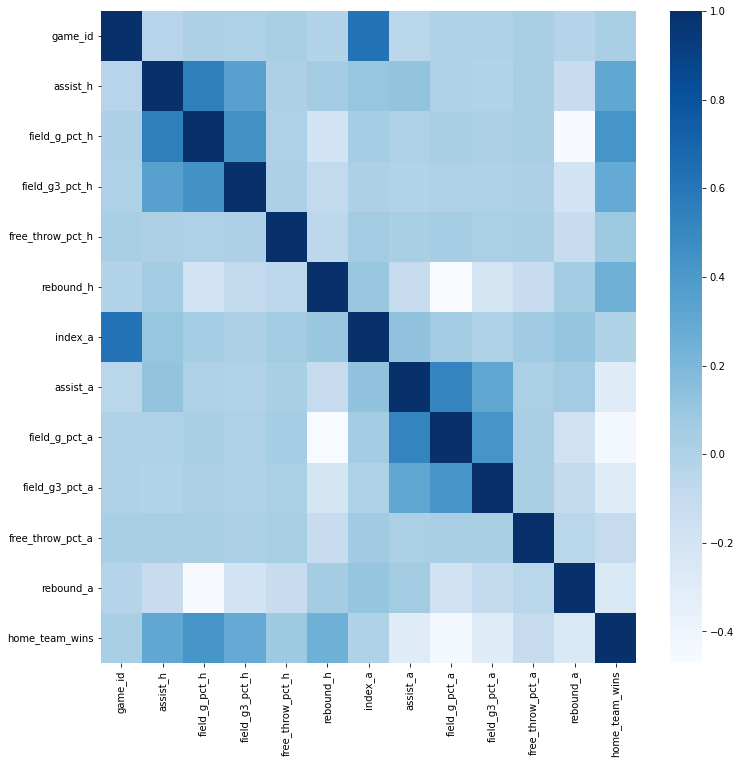

In [923]:
plt.figure(figsize=(12,12))
sns.heatmap(df_train.corr('pearson'), cmap='Blues', annot=False);

What would a naive model predict?

In [924]:
df_train.groupby(['home_team_wins'])['home_team_wins'].count() / df_train.shape[0]

home_team_wins
0    0.409637
1    0.590363
Name: home_team_wins, dtype: float64

In [925]:
df_val.groupby(['home_team_wins'])['home_team_wins'].count() / df_val.shape[0]

home_team_wins
0    0.405352
1    0.594648
Name: home_team_wins, dtype: float64

About 60% if we vie for the home team

### Predictions with SKLearn

In [926]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

import time

In [927]:
# create instances of our models
log_reg = LogisticRegression()
tree = DecisionTreeClassifier()
rand_forest = RandomForestClassifier(random_state=42)
ada_boost = AdaBoostClassifier(random_state=42)

test_models = [log_reg, tree, rand_forest, ada_boost]#, cat_class]

In [928]:
def train_model(model, X, y):
    '''
    Args:
    model -  A model to train
    X - Pandas Dataframe or Numpy array -  A dataset to use in training the model
    y - Pandas Dataframe or Numpy array -  A dataset of label classes to use in training the model
    Return:
    trained_model - A trained model
    train_time  (float) - The time taken to train the model
    '''  
    
    print(f'training: {model.__class__.__name__}')
    start = time.time()
    
    #train the model
    trained_model = model.fit(X, y)
    
    end = time.time()
    print('Training Concluded') 
    
    train_time = end - start
    
    print(f'Model trained in {train_time} seconds')
    
    return trained_model, train_time

 
def predict(model, y):
    '''
    Args:
    model -  A model to make predictions from
    y - Pandas Dataframe or Numpy Array - A dataset with which to make predictions
    Return:
    Numpy Array -  A numpy array of model predictions
    prediction_time  (float) - The time taken to make a prediction the model
    '''
    print('Evaluating')
    
    start = time.time()
    
    predicted = model.predict(y)
    
    end = time.time()
    
    prediction_time = end - start
    
    return predicted, prediction_time


def score(model, y, predictions, scoring_metric):
    '''
    Args:
    data - Pandas Dataframe - A dataset with a "prediction" column
    metric sklearn_class -  A scoring metric from the sklearn library
    Return:
    score - The score of the model
    '''
    print(f'Evaluating Model with {scoring_metric.__name__}')
    
    score = scoring_metric(y, predictions)
    
    print(f'The {scoring_metric.__name__} for {model.__class__.__name__} is:{score}')
    
    return score

In [929]:
results = {}
saved_model = []
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

for model in test_models:
    model_name = model.__class__.__name__

    #training our model
    trained_model, train_time = train_model(model, scaled_X_train, y_train)
    
    #predictions on our val and training dataset
    val_predicted, val_prediction_time = predict(trained_model, scaled_X_val)
    train_predicted, train_prediction_time = predict(trained_model, scaled_X_train)
    
    #scoring our test predictions 
    val_f1_score = score(model, y_val, val_predicted, f1_score)
    val_acc_score = score(model, y_val, val_predicted, accuracy_score)

    
    #scoring our training predictions
    train_f1_score = score(model, y_train, train_predicted, f1_score)
    train_acc_score = score(model, y_train, train_predicted, accuracy_score)
    
    #saving our metrics
    results[model_name] = {}
    
    results[model_name]['training_time'] = train_time
    
    results[model_name]['val_prediction_time'] = val_prediction_time
    results[model_name]['train_prediction_time'] = train_prediction_time
    
    results[model_name]['val_f1_score'] = val_f1_score
    results[model_name]['val_acc_score'] = val_acc_score
    
    results[model_name]['train_f1_score'] = train_f1_score
    results[model_name]['train_acc_score'] = train_acc_score
    
    saved_model.append(trained_model)

training: LogisticRegression
Training Concluded
Model trained in 0.0332789421081543 seconds
Evaluating
Evaluating
Evaluating Model with f1_score
The f1_score for LogisticRegression is:0.8649289099526065
Evaluating Model with accuracy_score
The accuracy_score for LogisticRegression is:0.8377455166524338
Evaluating Model with f1_score
The f1_score for LogisticRegression is:0.8666189697465249
Evaluating Model with accuracy_score
The accuracy_score for LogisticRegression is:0.8408051235132662
training: DecisionTreeClassifier
Training Concluded
Model trained in 0.16798686981201172 seconds
Evaluating
Evaluating
Evaluating Model with f1_score
The f1_score for DecisionTreeClassifier is:0.7914081145584725
Evaluating Model with accuracy_score
The accuracy_score for DecisionTreeClassifier is:0.7512097922003985
Evaluating Model with f1_score
The f1_score for DecisionTreeClassifier is:1.0
Evaluating Model with accuracy_score
The accuracy_score for DecisionTreeClassifier is:1.0
training: RandomFores

In [930]:
grid_results = pd.DataFrame(results)
grid_results = grid_results.reindex(['training_time','train_prediction_time','val_prediction_time','train_acc_score', 'val_acc_score','train_f1_score','val_f1_score'])
grid_results

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier
training_time,0.033279,0.167987,3.552502,1.035229
train_prediction_time,0.001152,0.003868,0.396019,0.113769
val_prediction_time,0.000891,0.001563,0.113825,0.034798
train_acc_score,0.840805,1.000000,1.000000,0.837633
val_acc_score,0.837746,0.751210,0.832337,0.820666
train_f1_score,0.866619,1.000000,1.000000,0.863683
val_f1_score,0.864929,0.791408,0.861118,0.850285


In [931]:
from sklearn.model_selection import GridSearchCV

In [932]:
params = {}
pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                 ('scaler', StandardScaler()),
                 ('clf',RandomForestClassifier())])
cv = GridSearchCV(pipe, param_grid=params)

In [933]:
parameters = {'clf__n_estimators':list(range(1,30,10))}

cv = GridSearchCV(pipe, parameters, verbose=1)

cv.fit(X_train, y_train)

y_pred = cv.predict(X_val)

accuracy_score(y_pred,y_val)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.8309137489325363

In [934]:
y_pred = cv.predict(X_test)

accuracy_score(y_pred, y_test)

0.8232783153101878

In [935]:
cv.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf', RandomForestClassifier(n_estimators=21))])